In [2]:
import numpy as np
import pandas as pd
from textwrap import wrap
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as mticker
import sys, os
from topicpy.hsbmpy import plot_topic_size, get_max_available_L
from topicpy.hypergeom import parameters_for_hypergeometric, build_map, plot_map

In [3]:
directory=f"/home/jovyan/work/phd/datasets/tcga/BRCA/mirna/"
os.chdir(directory)

In [4]:
L = get_max_available_L(directory, "trisbm")

In [5]:
os.listdir()

['gback_keyword.txt',
 'trisbm',
 'mainTable_hv.csv',
 '.empty',
 'Enrichr',
 'gback_word.txt',
 'trisbm|metadatum2|l1',
 'mainTable_all.csv',
 'gback.txt',
 'gback_ensg_keyword.txt',
 'files.dat',
 'pvalues_acrosstopic_trisbm_(0).pdf',
 'pvalues_acrosstopic_trisbm_(2).pdf',
 'pvalue_categories_trisbm_(2).pdf',
 'gsea',
 'pvalues_acrosstopics_trisbm_(1).pdf',
 'gback_ensg.txt',
 'trisbm|metadatum4|l1',
 'pvalue_categories_trisbm_(1).pdf',
 'pvalue_categories_trisbm_(0).pdf',
 'topsbm',
 'gback_ensg_word.txt']

# Geneontology

In [6]:
from topicpy.geneontology import get_ontology_df, ensg_to_symbol
from topicpy.tableanalyser import get_symbol
import gseapy as gs

In [7]:
l=L-1
algorithm = "trisbm"
kind = "keyword", "metadata"
#kind = "word", "topics"
df_topics = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_{kind[1]}.csv")
df_topics_smooth = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_{kind[0]}-dist.csv",index_col=0)
df_topics_smooth.index = [g[:15] for g in df_topics_smooth.index]
print(f"level {l} with {df_topics.shape[1]} {kind[1]}")

level 1 with 6 metadata


In [8]:
def get_topic_over_thr(topic_name, q=0.05):
    topic = df_topics_smooth[topic_name]
    topic = topic[topic>0]
    topic = topic[topic>topic.quantile(q=q)]
    return topic.sort_values(ascending=False)

In [9]:
df_symbols= pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_pub_ensembl_id&col=md_ensembl_id&col=md_eg_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit", index_col=[0], sep='\t')

In [10]:
def get_sea():
    for g in df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]:
        yield get_symbol(g)

In [11]:
with open(f"gback_{kind[0]}.txt",'w') as f:
    list(map(lambda x: f.writelines(x+'\n') if len(x)>1 else None, get_sea()))
    
with open(f"gback_ensg_{kind[0]}.txt",'w') as f:
    list(map(lambda x: f.writelines(x[:15]+'\n')if len(x)>1 else None, df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]))

In [12]:
#gs.get_library_name()

In [13]:
#https://www.gsea-msigdb.org/gsea/downloads.jsp
gene_sets = ['GO_Molecular_Function_2018',
             'GO_Biological_Process_2018',
             'GO_Cellular_Component_2018',
             'Human_Phenotype_Ontology',
             'WikiPathways_2019_Human',
             '/home/jovyan/work/phd/MSigDB/c1.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c2.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c3.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c4.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c5.all.v7.1.symbols.gmt',
           #  '/home/jovyan/work/phd/MSigDB/c6.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c7.all.v7.1.symbols.gmt',
            ]

In [14]:
threshhold = 5e-1
cutoff = 5e-1
background = len([g for g in get_sea()])
os.system("mkdir -p gsea")
os.system("mkdir -p gsea/{}".format(algorithm))
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("gsea/%s/gsea_level_%d_%s_%d.csv"%(algorithm,l,kind[1],itopic+1), index_col=[0])
        print(topic)
    except:
        try:
            gene_list = ensg_to_symbol(df_topics.loc[:,topic].dropna().values)
            #gene_list = ensg_to_symbol(get_topic_over_thr(topic).index)
            #gene_list = list(df_topics.loc[:,topic].dropna().values)
            print(topic)
            enriched_topic = get_ontology_df(gene_list, cutoff=cutoff, threshhold = threshhold, gene_sets = gene_sets, background=background)
            enriched_topic = enriched_topic.sort_values(by=['Adjusted P-value'], ascending=True)[:20]
            enriched_topic.to_csv("gsea/%s/gsea_level_%d_%s_%d.csv"%(algorithm,l,kind[1],itopic+1))
        except:
            print(*sys.exc_info())
            continue
    print(enriched_topic)

Metadatum 1
Empty DataFrame
Columns: [Term, Adjusted P-value, Gene_set]
Index: []
Metadatum 2
Empty DataFrame
Columns: [Term, Adjusted P-value, Gene_set]
Index: []
Metadatum 3
Empty DataFrame
Columns: [Term, Adjusted P-value, Gene_set]
Index: []
Metadatum 4
Empty DataFrame
Columns: [Term, Adjusted P-value, Gene_set]
Index: []
Metadatum 5
Empty DataFrame
Columns: [Term, Adjusted P-value, Gene_set]
Index: []
Metadatum 6
Empty DataFrame
Columns: [Term, Adjusted P-value, Gene_set]
Index: []


In [20]:
topic_pvalues = []
topic_gos = []
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("gsea/%s/gsea_level_%d_%s_%d.csv"%(algorithm,l,kind[1],itopic+1))
        if len(enriched_topic.index) >0:
            p_val = np.sort(enriched_topic['Adjusted P-value'])[0]
            topic_pvalues.append(-np.log10(p_val))
            for goc in enriched_topic['Gene_set'][:10].unique():
                topic_gos.append(goc)
        print(topic)
    except:
        print("error", sys.exc_info()[0])

Metadatum 1
Metadatum 2
Metadatum 3
Metadatum 4
Metadatum 5
Metadatum 6


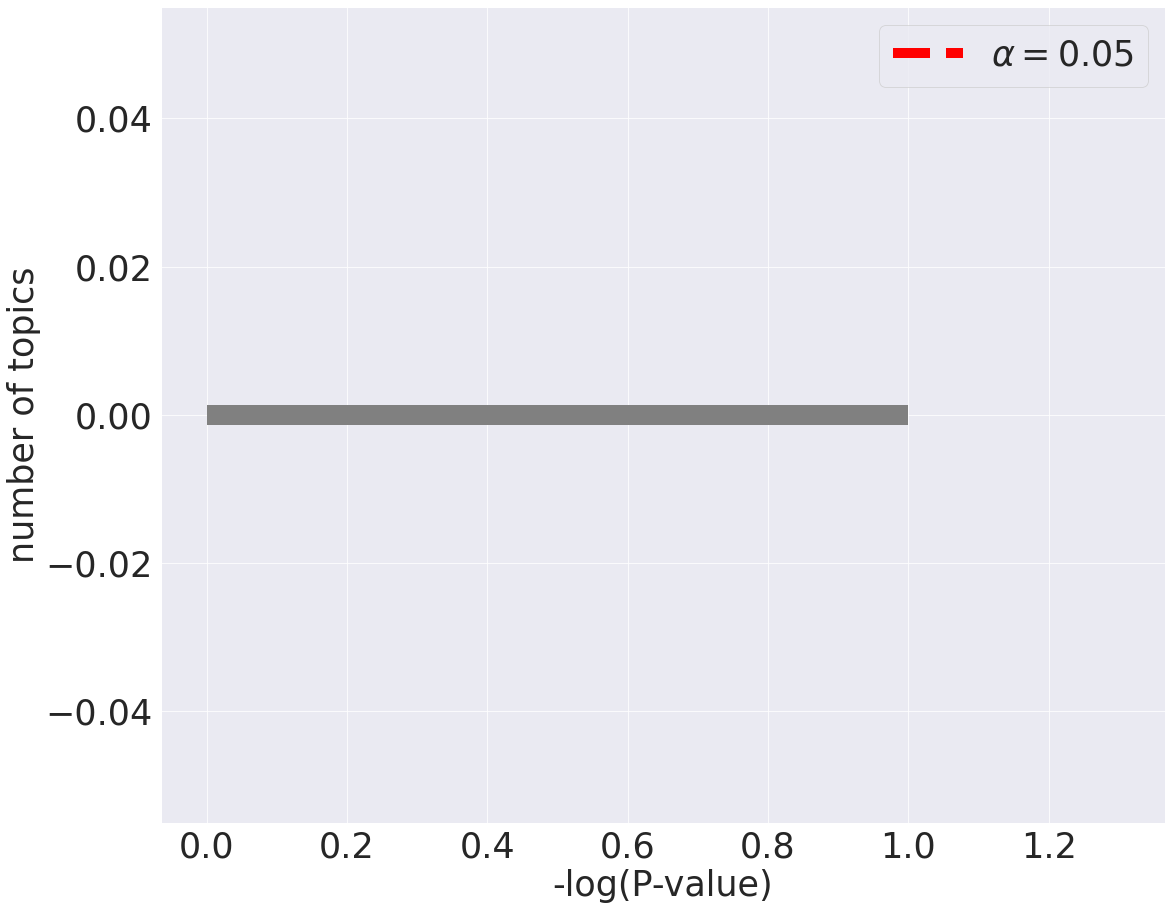

In [21]:
fig = plt.figure(figsize=(18,15))
x = np.arange(1,1+len(topic_pvalues))
c, _, _ = plt.hist(topic_pvalues, histtype='step', lw=20, bins=45, color="gray")
plt.vlines(-np.log10(0.05),0,np.max(c)*1.1, color="red", ls='--', lw=10, label="$\\alpha=0.05$")
plt.xlabel('-log(P-value)', fontsize=35)
plt.ylabel("number of topics", fontsize=35)
#plt.ylim(0,0.055)
#plt.yscale('log')
plt.legend(fontsize=35)
plt.tick_params(which="both",labelsize=35)
fig.savefig("%s/pvalues_across%s_%s_(%d).pdf"%(directory,kind[1],algorithm,l))

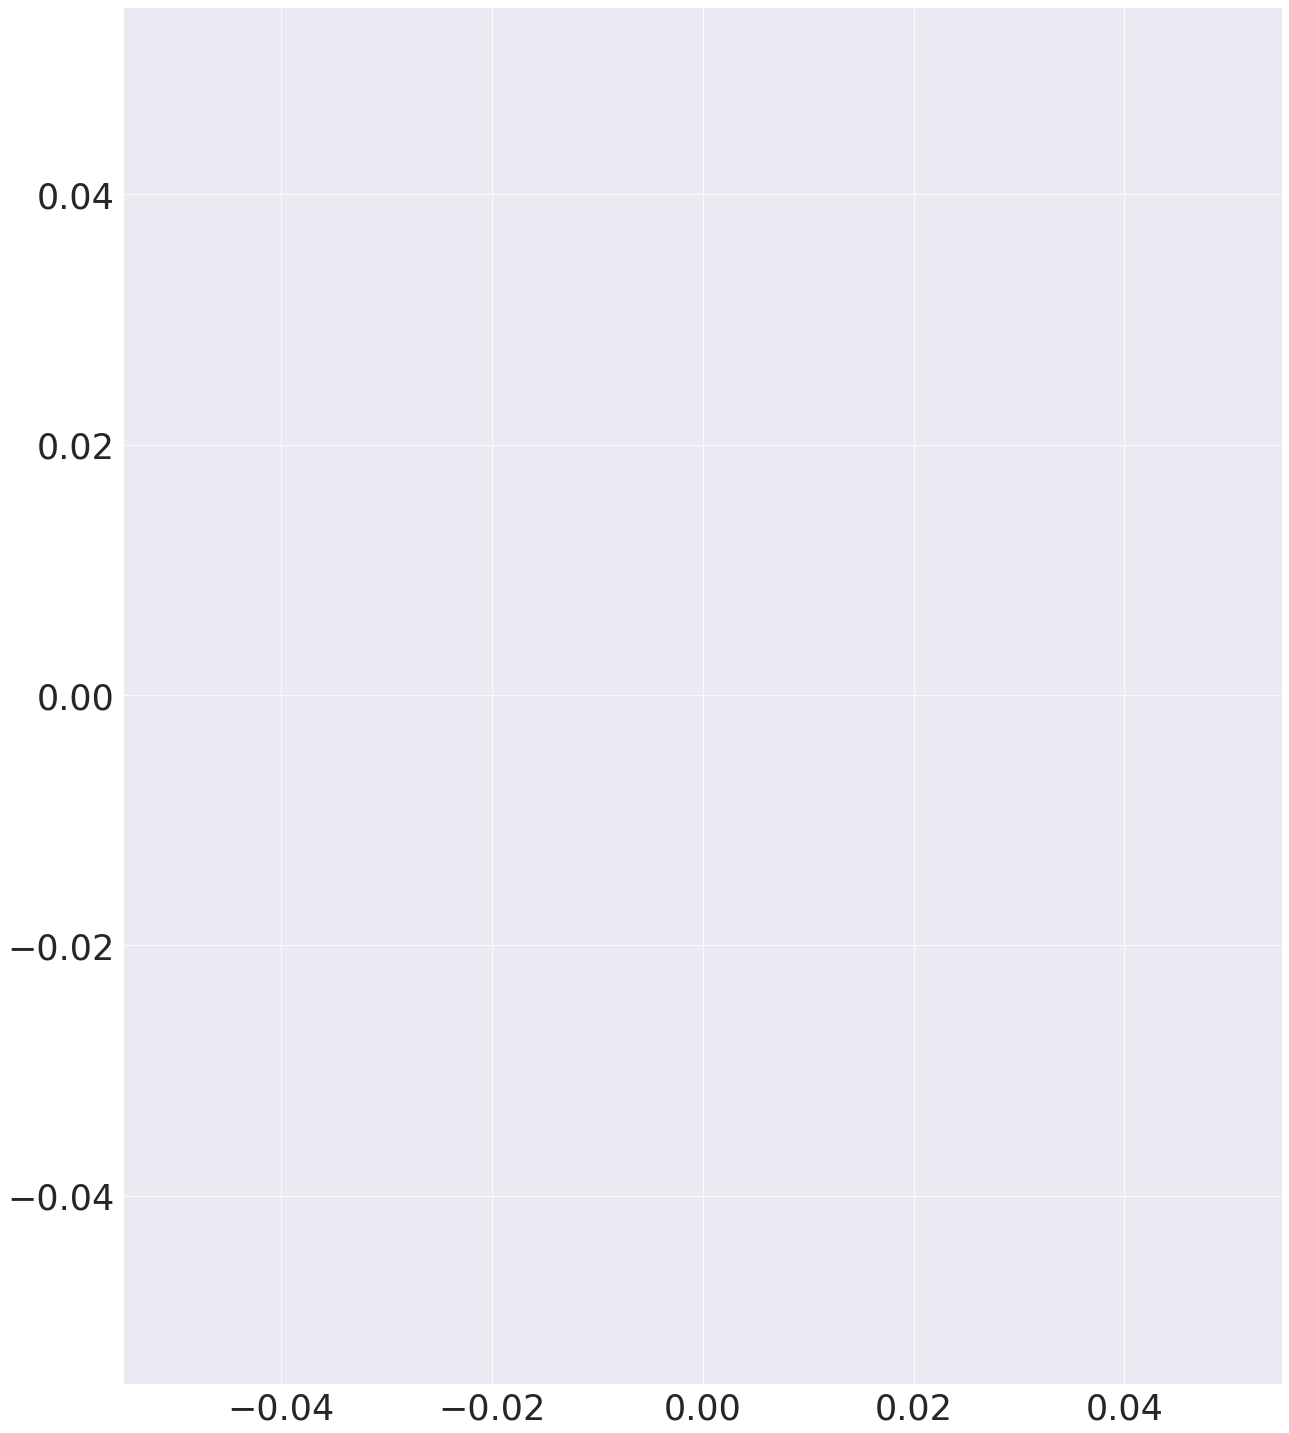

In [22]:
fig = plt.figure(figsize=(18,20))
gos, goscounts = np.unique(topic_gos, return_counts=True)
plt.barh(["\n".join(wrap(str(l).replace('_',' '),20)) for l in gos], goscounts)
plt.yticks(fontsize=15)
plt.tick_params(which="both",labelsize=35)
plt.tight_layout()
plt.show()
fig.savefig("%s/pvalue_categories_%s_%s_(%d).pdf"%(directory,algorithm,kind[1],l))